# Homework 2 Sokolov Andrey

# Preprocessing

#### Загружаем данные, убираем все года до 2000, убираем пустые связи и преобразуем связи из листа в список

In [1]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import math
import itertools
from copy import deepcopy
from matplotlib import pyplot as plt

In [2]:
terrorism = pd.read_csv("terrorism.csv")

In [3]:
t = terrorism[terrorism.year >= 2000].dropna()

In [4]:
idx = t.id.tolist()
related = t.related.tolist()

In [5]:
connections = []
for i in range(len(idx)):
    con = related[i].split(',')
    l = []
    for j in range(len(con)):
        s = con[j]
        k = int(''.join(m for m in s if m.isdigit()))
        if k != idx[i]:
            l.append(k)
    connections.append(l)

In [6]:
t['connections'] = connections

# Making graph

#### Теперь создаем графы, в качестве графов я взял года 2012 и 2013, из них взял три самые большие компоненты и связал между собой ребрами(каждая компонента к каждом по рандомным вершинам)

In [7]:
def make_nx_graph(year):
    g = nx.Graph()
    idx = year.id.tolist()
    con = year.connections.tolist()
    for i in range(len(idx)):
        for j in range(len(con[i])):
            g.add_edge(idx[i], con[i][j])
    return g

In [8]:
def make_bridges(year):
    y = t[t.year == year]
    bridges = []
    klik_nodes = []
    G = make_nx_graph(y)
    l = sorted(nx.connected_component_subgraphs(G), key=len)
    k = nx.Graph()
    for i in range(-1, -4, -1):
        klik_nodes.append(list(l[i].nodes()))
        k.add_edges_from(l[i].edges())
    comb = list(itertools.combinations([-1, -2, -3], 2))
    for i in comb:
        ftos = random.choice(list(l[i[0]].nodes()))
        stof = random.choice(list(l[i[1]].nodes()))
        k.add_edge(ftos, stof)
        k.add_edge(stof, ftos)
        bridges.append((ftos, stof))
    return k, klik_nodes, bridges

## Year 2012

#### Как видно все три компонента в 2012 году это полные графы

In [9]:
year2012, klin_nodes2012, bridges2012 = make_bridges(2012)

In [10]:
nodes2012 = len(year2012.nodes())
edges2012 = len(year2012.edges())
print('2012 nodes =', nodes2012, 'edges =', edges2012)

2012 nodes = 120 edges = 2356


In [11]:
for i in range(3):
    print(len(klin_nodes2012[i]))
    for j in range(len(klin_nodes2012[i])):
        print(year2012.degree(klin_nodes2012[i][j]), end=" ")
    print()

43
42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 43 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 43 
41
40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 41 41 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 
36
35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 36 35 35 35 35 35 35 35 35 35 35 35 35 36 35 35 35 35 35 35 


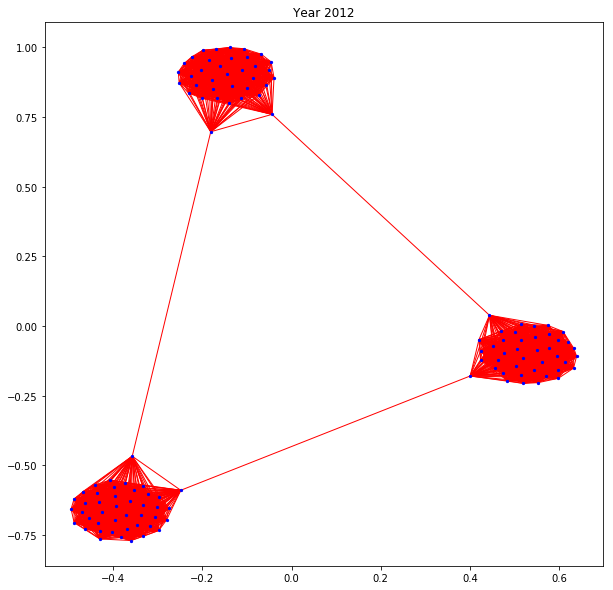

In [12]:
f = plt.figure(figsize=(10,10))
plt.title('Year 2012')
pos = nx.spring_layout(year2012)
nx.draw_networkx_nodes(year2012, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'blue', node_size = 5)
nx.draw_networkx_edges(year2012, pos, edge_color='r')
plt.show()

## Year 2013

#### Тоже видно, что все три компонента в 2013 году это полные графы

In [13]:
year2013, klin_nodes2013, bridges2013 = make_bridges(2013)

In [14]:
nodes2013 = len(year2013.nodes())
edges2013 = len(year2013.edges())
print('2013 nodes =', nodes2013, 'edges =', edges2013)

2013 nodes = 100 edges = 1634


In [15]:
for i in range(3):
    print(len(klin_nodes2013[i]))
    for j in range(len(klin_nodes2013[i])):
        print(year2013.degree(klin_nodes2013[i][j]), end=" ")
    print()

36
35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 36 35 35 36 35 35 35 
35
34 34 34 34 35 34 35 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 
29
28 28 29 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 29 28 28 28 28 28 28 


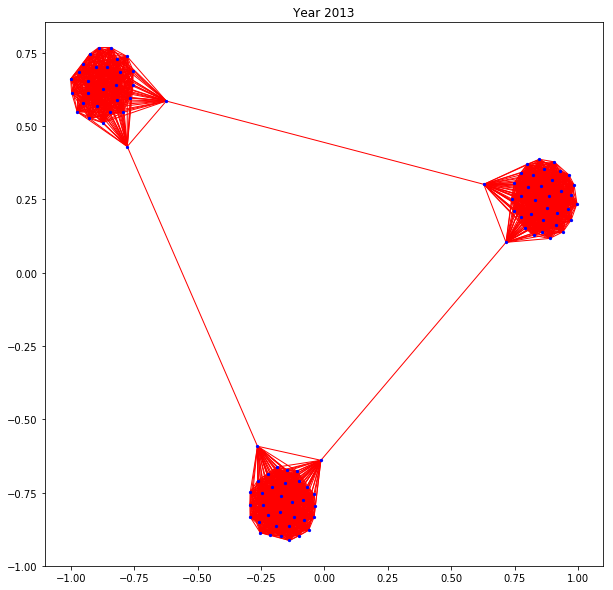

In [17]:
f = plt.figure(figsize=(10,10))
plt.title('Year 2013')
pos = nx.spring_layout(year2013)
nx.draw_networkx_nodes(year2013, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'blue', node_size = 5)
nx.draw_networkx_edges(year2013, pos, edge_color='r')
plt.show()

# Graph edit distance

#### Для того чтобы перевести один граф в дугой надо подогнать полные компоненты друг по друга, то есть сопоставить одному компоненту друго (по возрастанию), после чего либо добавлять вершины и соединять внутри компоненты ребрами со всеми либо наоборот удалять вершины, о смотреть чтобы вершины не относились к ребру связывающие компоненты.

In [18]:
def GED(year1, year2, klin_nodes1, klin_nodes2, bridges1):
    edit_graph = deepcopy(year1)
    all_vertexes = deepcopy(klin_nodes1)
    edit_vertexes = [[] for i in range(3)]
    edit_edges = [[] for i in range(3)]
    bridge_nodes = []
    for i in bridges1:
        bridge_nodes.append(i[0])
        bridge_nodes.append(i[1])
    num = 0
    cost = 0
    for i in range(3):
        if len(all_vertexes[i]) < len(klin_nodes2[i]):
            while len(all_vertexes[i]) < len(klin_nodes2[i]):
                all_vertexes[i].append(num)
                edit_vertexes[i].append(num)
                edit_graph.add_node(num)
                cost += 1
                print("adding vertex", num, "to graph 1, total cost =", cost)
                for j in range(len(all_vertexes[i]) - 1):
                    edit_graph.add_edge(num, all_vertexes[i][j])
                    edit_graph.add_edge(all_vertexes[i][j], num)
                    edit_edges[i].append((num, all_vertexes[i][j]))
                    cost += 1
                    print("adding edge between", num, "and", all_vertexes[i][j], "to graph 1, total cost =", cost)
                num += 1
        elif len(all_vertexes[i]) > len(klin_nodes2[i]):
            while len(all_vertexes[i]) > len(klin_nodes2[i]):
                f = 0
                deleted = -1
                while f == 0:
                    deleted = random.choice(all_vertexes[i])
                    if deleted not in bridge_nodes:
                        f = 1
                ed = edit_graph.degree(deleted)
                edit_graph.remove_node(deleted)
                all_vertexes[i].remove(deleted)
                cost += 1 + ed
                print("deleting node", deleted, "and all her edges, there are", ed, "of them, total cost =", cost)
    print("total cost =", cost)
    return edit_graph, edit_vertexes, edit_edges

## Edit from Year 2012 to Year 2013

#### Видно что в 2012 году в компонентах больше вершин пожтому их надо удалять, и в итоге мы совершили 742 действия (удалили 20 вершин и 722 ребра которые были у этих вершин)
На графике показаны удаленные вершины синим цветом

In [19]:
edit_graph2012, edit_vertex2012, edit_edges2012 = GED(year2012, year2013, klin_nodes2012, klin_nodes2013, bridges2012)

deleting node 201204190047 and all her edges, there are 42 of them, total cost = 43
deleting node 201204190012 and all her edges, there are 41 of them, total cost = 85
deleting node 201204190017 and all her edges, there are 40 of them, total cost = 126
deleting node 201204190046 and all her edges, there are 39 of them, total cost = 166
deleting node 201204190013 and all her edges, there are 38 of them, total cost = 205
deleting node 201204190004 and all her edges, there are 37 of them, total cost = 243
deleting node 201204190039 and all her edges, there are 36 of them, total cost = 280
deleting node 201207230006 and all her edges, there are 40 of them, total cost = 321
deleting node 201207230037 and all her edges, there are 39 of them, total cost = 361
deleting node 201207230046 and all her edges, there are 38 of them, total cost = 400
deleting node 201207230031 and all her edges, there are 37 of them, total cost = 438
deleting node 201207230018 and all her edges, there are 36 of them,

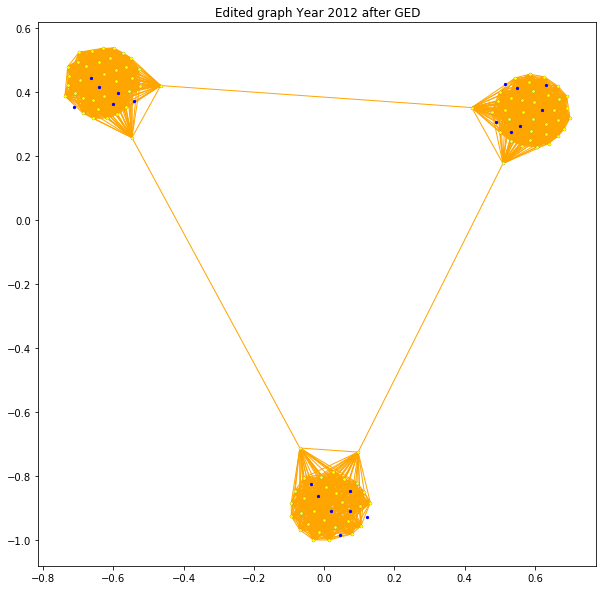

In [21]:
f = plt.figure(figsize=(10,10))
plt.title('Edited graph Year 2012 after GED')
pos = nx.spring_layout(year2012)
nx.draw_networkx_nodes(year2012, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'blue', node_size = 5)
nx.draw_networkx_nodes(year2012, pos, nodelist = edit_graph2012.nodes(), cmap=plt.get_cmap('jet'), 
                       node_color = 'yellow', node_size = 5)
nx.draw_networkx_edges(year2012, pos, edgelist = edit_graph2012.edges(), edge_color='orange')
plt.show()

## Edit from Year 2013 to Year 2012

#### Тут же видно что в 2013 году все компоненты меньше, поэтому мы прибавляем вершины и соединяем их ребрами ко всем в компоненте, на все мы потратили соответсвенно так же 742 действия (добавление 20 верши и 722 ребер между ними)
На графике показаны добавленные вершины желтым цветом, а добавленные ребра оранжевым цветом

In [22]:
edit_graph2013, edit_vertex2013, edit_edges2013= GED(year2013, year2012, klin_nodes2013, klin_nodes2012, bridges2013)

adding vertex 0 to graph 1, total cost = 1
adding edge between 0 and 201310090029 to graph 1, total cost = 2
adding edge between 0 and 201310090032 to graph 1, total cost = 3
adding edge between 0 and 201310090033 to graph 1, total cost = 4
adding edge between 0 and 201310090036 to graph 1, total cost = 5
adding edge between 0 and 201310090037 to graph 1, total cost = 6
adding edge between 0 and 201310090038 to graph 1, total cost = 7
adding edge between 0 and 201310090039 to graph 1, total cost = 8
adding edge between 0 and 201310090040 to graph 1, total cost = 9
adding edge between 0 and 201310090041 to graph 1, total cost = 10
adding edge between 0 and 201310090042 to graph 1, total cost = 11
adding edge between 0 and 201310090043 to graph 1, total cost = 12
adding edge between 0 and 201310090044 to graph 1, total cost = 13
adding edge between 0 and 201310090045 to graph 1, total cost = 14
adding edge between 0 and 201310090046 to graph 1, total cost = 15
adding edge between 0 and 2

adding edge between 8 and 201304150043 to graph 1, total cost = 336
adding edge between 8 and 201304150044 to graph 1, total cost = 337
adding edge between 8 and 201304150045 to graph 1, total cost = 338
adding edge between 8 and 201304150048 to graph 1, total cost = 339
adding edge between 8 and 201304150049 to graph 1, total cost = 340
adding edge between 8 and 201304150059 to graph 1, total cost = 341
adding edge between 8 and 201304150060 to graph 1, total cost = 342
adding edge between 8 and 201304150061 to graph 1, total cost = 343
adding edge between 8 and 201304150006 to graph 1, total cost = 344
adding edge between 8 and 201304150008 to graph 1, total cost = 345
adding edge between 8 and 201304150009 to graph 1, total cost = 346
adding edge between 8 and 201304150010 to graph 1, total cost = 347
adding edge between 8 and 201304150011 to graph 1, total cost = 348
adding edge between 8 and 201304150012 to graph 1, total cost = 349
adding edge between 8 and 201304150013 to graph 

adding edge between 16 and 201310290094 to graph 1, total cost = 627
adding edge between 16 and 201310290016 to graph 1, total cost = 628
adding edge between 16 and 201310290031 to graph 1, total cost = 629
adding edge between 16 and 201310290033 to graph 1, total cost = 630
adding edge between 16 and 201310290034 to graph 1, total cost = 631
adding edge between 16 and 201310290035 to graph 1, total cost = 632
adding edge between 16 and 201310290036 to graph 1, total cost = 633
adding edge between 16 and 201310300069 to graph 1, total cost = 634
adding edge between 16 and 13 to graph 1, total cost = 635
adding edge between 16 and 14 to graph 1, total cost = 636
adding edge between 16 and 15 to graph 1, total cost = 637
adding vertex 17 to graph 1, total cost = 638
adding edge between 17 and 201310290072 to graph 1, total cost = 639
adding edge between 17 and 201310290074 to graph 1, total cost = 640
adding edge between 17 and 201310290075 to graph 1, total cost = 641
adding edge betwee

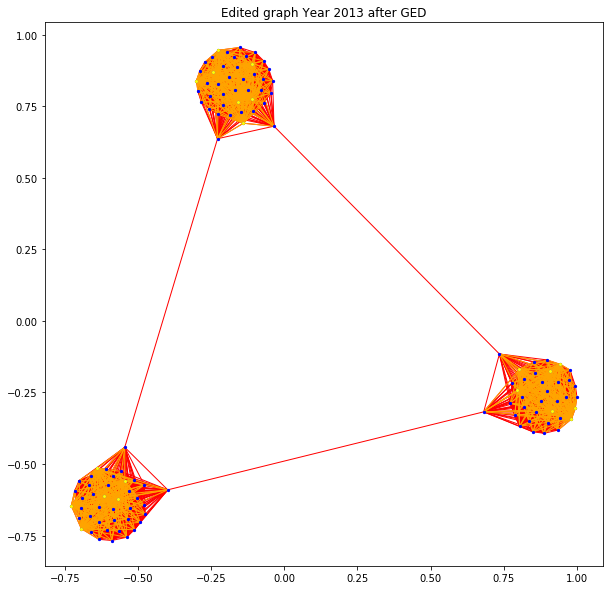

In [23]:
f = plt.figure(figsize=(10,10))
plt.title('Edited graph Year 2013 after GED')
pos = nx.spring_layout(edit_graph2013)
nx.draw_networkx_nodes(edit_graph2013, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'blue', node_size = 5)
for i in range(3):
    nx.draw_networkx_nodes(edit_graph2013, pos, nodelist = edit_vertex2013[i], cmap=plt.get_cmap('jet'), 
                       node_color = 'yellow', node_size = 5)
nx.draw_networkx_edges(edit_graph2013, pos, edge_color='r')
for i in range(3):
    nx.draw_networkx_edges(edit_graph2013, pos, edgelist = edit_edges2013[i], edge_color='orange')  
plt.show()

# Easy metrics

## diameter, eccentricity, periphery

#### Как мы видим и в том и втом году eccentricity каждой вершины равно 3, что означает что радиус и диаметр равен 3 и в 2012 году и в 2013, а также что в periphery входят все вершины и в том и втом году.
#### Это показывает что наши графы сильно похожи

In [24]:
def diameter_eccentricity_periphery(year):
    nodes = list(year.nodes())
    eccen = dict()
    for i in range(len(nodes)):
        max_len = 0
        for j in range(len(nodes)):
            s = nx.shortest_path(year, nodes[i], nodes[j])
            if len(s) - 1 > max_len:
                max_len = len(s) - 1
        eccen[nodes[i]] = max_len
    diameter = max(eccen.values())
    radius = min(eccen.values())
    periph = []
    for i in range(len(nodes)):
        if eccen[nodes[i]] == diameter:
            periph.append(nodes[i])
    return eccen, diameter, radius, periph

#### 2012 год

In [25]:
eccen2012, diam2012, radius2012, periph2012 = diameter_eccentricity_periphery(year2012)

In [26]:
print('2012 диаметр =', diam2012, 'радиус =', radius2012)

2012 диаметр = 3 радиус = 3


In [27]:
nx.eccentricity(year2012) == eccen2012

True

In [28]:
eccen2012

{201204190002: 3,
 201204190003: 3,
 201204190004: 3,
 201204190005: 3,
 201204190006: 3,
 201204190007: 3,
 201204190008: 3,
 201204190010: 3,
 201204190011: 3,
 201204190012: 3,
 201204190013: 3,
 201204190014: 3,
 201204190015: 3,
 201204190017: 3,
 201204190018: 3,
 201204190019: 3,
 201204190020: 3,
 201204190021: 3,
 201204190022: 3,
 201204190023: 3,
 201204190024: 3,
 201204190025: 3,
 201204190026: 3,
 201204190027: 3,
 201204190028: 3,
 201204190029: 3,
 201204190030: 3,
 201204190031: 3,
 201204190032: 3,
 201204190033: 3,
 201204190034: 3,
 201204190035: 3,
 201204190036: 3,
 201204190037: 3,
 201204190038: 3,
 201204190039: 3,
 201204190040: 3,
 201204190041: 3,
 201204190042: 3,
 201204190043: 3,
 201204190046: 3,
 201204190047: 3,
 201204190048: 3,
 201207230005: 3,
 201207230006: 3,
 201207230007: 3,
 201207230008: 3,
 201207230009: 3,
 201207230010: 3,
 201207230011: 3,
 201207230012: 3,
 201207230013: 3,
 201207230014: 3,
 201207230015: 3,
 201207230017: 3,
 201207230

#### 2013 год

In [29]:
eccen2013, diam2013, radius2013, periph2013 = diameter_eccentricity_periphery(year2013)

In [30]:
print('2013 диаметр =', diam2013, 'радиус =', radius2013)

2013 диаметр = 3 радиус = 3


In [31]:
nx.eccentricity(year2013) == eccen2013

True

In [32]:
eccen2013

{201310090029: 3,
 201310090032: 3,
 201310090033: 3,
 201310090036: 3,
 201310090037: 3,
 201310090038: 3,
 201310090039: 3,
 201310090040: 3,
 201310090041: 3,
 201310090042: 3,
 201310090043: 3,
 201310090044: 3,
 201310090045: 3,
 201310090046: 3,
 201310090047: 3,
 201310090048: 3,
 201310090049: 3,
 201310090050: 3,
 201310090051: 3,
 201310090052: 3,
 201310090053: 3,
 201310090054: 3,
 201310090055: 3,
 201310090056: 3,
 201310090057: 3,
 201310090058: 3,
 201310090061: 3,
 201310090062: 3,
 201310090102: 3,
 201310090103: 3,
 201310090104: 3,
 201310090105: 3,
 201310090106: 3,
 201310090107: 3,
 201310090108: 3,
 201310090109: 3,
 201304150016: 3,
 201304150006: 3,
 201304150008: 3,
 201304150009: 3,
 201304150010: 3,
 201304150011: 3,
 201304150012: 3,
 201304150013: 3,
 201304150014: 3,
 201304150015: 3,
 201304150018: 3,
 201304150019: 3,
 201304150020: 3,
 201304150021: 3,
 201304150022: 3,
 201304150023: 3,
 201304150024: 3,
 201304150025: 3,
 201304150026: 3,
 201304150

## Girth

#### Так как наши графы это полные графы связанные мостами, то минимальный цинкл длинны 3 и в том и в том, еще один параметр схожести

# Wiener index

#### Так как wiener это сумма всех кратчайших путей, а сумма на прямую зависит от количиства ребер, пожтому в качестве метрики я взял отношения коефициента на количество ребер, и по результатом видим то результат в наших годах сильно похожи что еще раз показывает, что наши графы сильно похожи

In [33]:
def wiener_ind(year):
    wiener_index = 0
    nodes = list(year.nodes())
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            s = nx.shortest_path(year, nodes[i], nodes[j])
            wiener_index += len(s) - 1
    return wiener_index

#### 2012

In [34]:
wiener2012 = wiener_ind(year2012)
wiener2012

16474

In [35]:
nx.wiener_index(year2012)

16474.0

#### 2013

In [36]:
wiener2013 = wiener_ind(year2013)
wiener2013

11388

In [37]:
nx.wiener_index(year2013)

11388.0

#### Подставление метрик

In [40]:
wiener_m2012 = wiener2012/edges2012
wiener_m2013 = wiener2013/edges2013
print('wiener после применения метрики в 2012 году =', wiener_m2012, 
          '\nwiener после применения метрики в 2013 году =', wiener_m2013,
            '\nотношение =', wiener_m2012 / wiener_m2013)

wiener после применения метрики в 2012 году = 6.992359932088285 
wiener после применения метрики в 2013 году = 6.969400244798042 
отношение = 1.0032943562550278


# Hosoya index

#### Для вычисления индекса Хосои, я сначала посчитал телефонные номера до 80, (T(n) =T(n-1)+(n-1)* T(n-2)), так как для полных графах число парасочетаний жто телевонный номер от вершин. А если у нас несколько полных графов то их число парасочетаний это перемножение числа их личных парасочетаний, если же между графами есть ребро, то число парасочетаний это произведение (если мост не в парасочетание) и произведение без одной вершины у каждого (если ребро в парасочетание), пожтому я перебраю варианты вклюения и исключения мостов для подсчет индекса Хосои

In [41]:
#посчет телефонных номеров
pairs_number = [0] * 200
pairs_number[0] = 1
pairs_number[1] = 1
pairs_number[2] = 2
def pairs_n(n):
    if (pairs_number[n] != 0):
        return pairs_number[n]
    if (pairs_number[n - 2] != 0):
        if (pairs_number[n - 1] != 0):
            pairs_number[n] = pairs_number[n - 1] + (n - 1) * pairs_number[n - 2]
        else:
            pairs_number[n] = pairs_n(n - 1) + (n - 1) * pairs_number[n - 2]
    else:
        pairs_number[n] = pairs_n(n - 1) + (n - 1) * pairs_n(n - 2)
    return pairs_number[n]
pairs_n(140)

52258951049500325762888623007313057163147212476488393126879268077980537745243243649416457935443868038845247134866948317249536

In [42]:
def hos_ind(bridges, klin_nodes):
    hosoya_index = 0
    for i in range(len(bridges) + 1):
        included_bridges = list(itertools.combinations(bridges, i))
        for brs in included_bridges:
            vertex_in_pairs = []
            for k in range(len(klin_nodes)):
                vertex_in_pairs.append(len(klin_nodes[k]))
            for b in brs:
                for l in range(2):
                    for d in range(len(klin_nodes)):
                        if b[l] in klin_nodes[d]:
                            vertex_in_pairs[d] -= 1
            mult = 1
            for m in range(len(vertex_in_pairs)):
                mult *= pairs_n(vertex_in_pairs[m])
            hosoya_index += mult
    return hosoya_index

#### 2012

In [43]:
hosoya2012 = hos_ind(bridges2012, klin_nodes2012)
print("Hosoya index for 2012 =", hosoya2012)

Hosoya index for 2012 = 476577540703877063351876266355756386865248483327707404755032938442178531688448


#### 2013

In [44]:
hosoya2013 = hos_ind(bridges2013, klin_nodes2013)
print("Hosoya index for 2013 =", hosoya2013)

Hosoya index for 2013 = 22637663953307845433107542322685078315974901849899314058362880


#### Метрика
#### В качестве варианта метрики для индекса хосои я решил брать корень степени числа ребер в графе, так как паросочетания набор ребер это жает вероятность того что ребро будет в парасоче, и если вероятности близки значит что графы похожи, что и видно из коефициента

In [67]:
m2012 = hosoya2012 ** (1/edges2012)
m2013 = hosoya2013 ** (1/edges2013)
m2013/m2012

1.010598178739897

####  В качестве дополнительной метрики для индекса хосои можно взять отношение к плотности графа, так как количество парасочетаний связано с плотнотью графа, но результат получился неочень.

In [60]:
D2012 = 2 * nodes2012 / (edges2012 * (edges2012 - 1))
D2013 = 2 * nodes2013 / (edges2013 * (edges2013 - 1))
(hosoya2012 / D2012) / (hosoya2013 / D2013)

3.647948325182364e+16

# Graph Core

#### Так как ядро графа - это внешняя и внутренняя устойчивость (то есть все вершины должны быть смежны с вершинами ядра, но сами вершины в ядре не должны быть смежными) поэтому любая вершина в полном графе является ядром, а значит если у нас связка из полных графоф то мы просто берем ребра из связных графов и не берем те что являются мостами.
#### В том и в другом году, так как у нас 3 графа полных, поэтому в ядре 3 вершины в обоих годах, а значит это еще один показатель схоэести графов

In [46]:
def find_core(bridges, klin_nodes):
    core_nodes = []
    bridge_nodes = []
    for i in bridges:
        bridge_nodes.append(i[0])
        bridge_nodes.append(i[1])
    for i in range(len(klin_nodes)):
        f = 0
        core_n = -1
        while f == 0:
            core_n = random.choice(klin_nodes[i])
            if core_n not in bridge_nodes:
                f = 1
        core_nodes.append(core_n)
    return core_nodes

#### 2012 (ядро на графе - желтые вершины)

In [47]:
core2012 = find_core(bridges2012, klin_nodes2012)

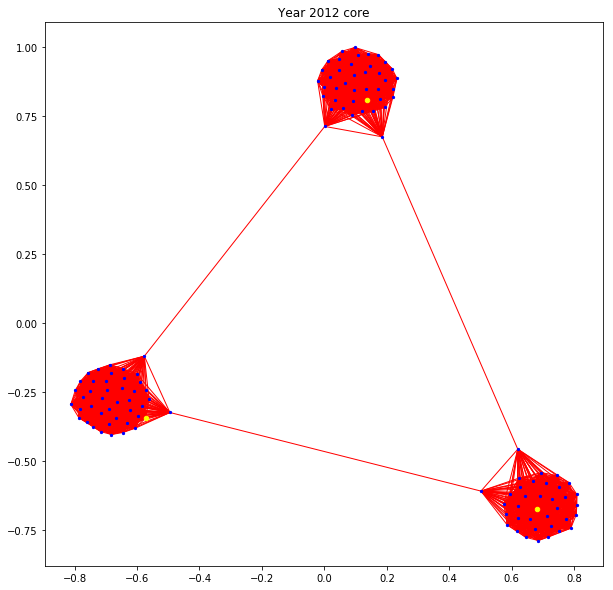

In [56]:
f = plt.figure(figsize=(10,10))
plt.title('Year 2012 core')
pos = nx.spring_layout(year2012)
nx.draw_networkx_nodes(year2012, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'blue', node_size = 5)
nx.draw_networkx_nodes(year2012, pos, nodelist = core2012, cmap=plt.get_cmap('jet'), 
                       node_color = 'yellow', node_size = 20)
nx.draw_networkx_edges(year2012, pos, edge_color='r')
plt.show()

#### 2013 (ядро на графе - желтые вершины

In [49]:
core2013 = find_core(bridges2013, klin_nodes2013)
core2013

[201310090045, 201304150049, 201310290031]

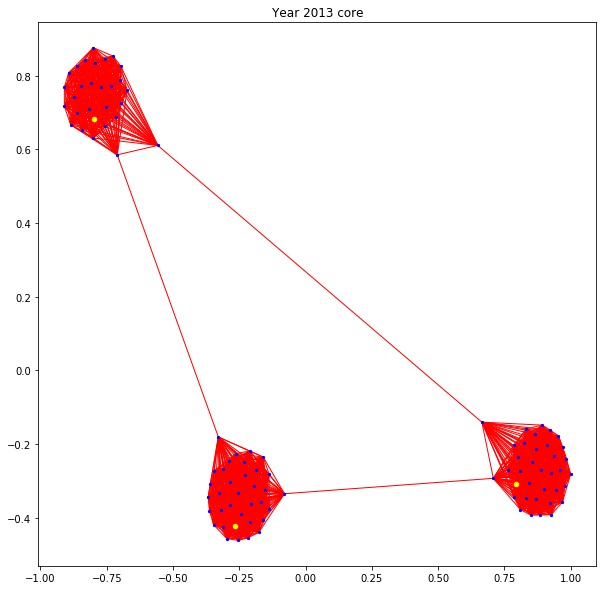

In [53]:
f = plt.figure(figsize=(10,10))
plt.title('Year 2013 core')
pos = nx.spring_layout(year2013)
nx.draw_networkx_nodes(year2013, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'blue', node_size = 5)
nx.draw_networkx_nodes(year2013, pos, nodelist = core2013, cmap=plt.get_cmap('jet'), 
                       node_color = 'yellow', node_size = 20)
nx.draw_networkx_edges(year2013, pos, edge_color='r')
plt.show()